# Using `keras`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 

Using TensorFlow backend.


## Access to backend

The backend provides a consistent interface for accessing useful data manipulaiton functions, similar to numpy. It uses whaterver engine is powerinng `keras` - in our case, it uses `TensorFlow`, but it can also use `Theano` and `CNTK` - in each case, the API is the same. 

See [docs](https://keras.io/backend/)

In [4]:
import keras.backend as K

In [5]:
m = 5
n = 3
p = 4

a = K.random_normal([m, n], mean=0, stddev=1)
b = K.random_normal([n, p], mean=0, stddev=1)
c = K.dot(a, b)

K.eval(c)

array([[-0.82068974,  2.9188094 , -0.5856401 ,  0.20538841],
       [-0.40368164, -2.8094885 ,  0.5052769 ,  0.7337118 ],
       [-0.03530191,  0.33472002,  0.13317138,  0.9637028 ],
       [ 1.6380395 ,  2.0245502 ,  0.22507435,  1.0330583 ],
       [ 0.291666  , -3.5163243 ,  0.5908829 , -0.10566113]],
      dtype=float32)

## Linear regression

In [6]:
np.random.seed(123)

In [7]:
N = 10
W_true = 2
b_true = 1
eps = np.random.normal(0, 1, (N, 1))
X_obs = np.arange(N).reshape((N, 1))
y_obs = np.reshape(W_true * X_obs + b_true + eps, (-1, 1))

In [8]:
X_obs.shape

(10, 1)

### Build model

In [9]:
model = Sequential()
model.add(Dense(units=1, input_dim=1, activation=None))

### Compile model with optimizer, loss function and evaluaiton metrics

In [10]:
model.compile(
    optimizer='rmsprop', 
    loss='mse', 
    metrics=['mse']) 

### Fit model

In [11]:
history = model.fit(
    X_obs, 
    y_obs,
    batch_size=N, 
    epochs=1000,
    verbose=0)

### Visualize progress

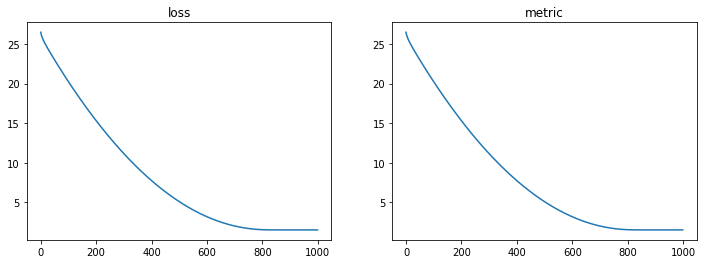

In [12]:
plt.figure(figsize=(12,4))
hist = history.history
plt.subplot(121)
plt.plot(hist['loss'])
plt.title('loss')
plt.subplot(122)
plt.plot(hist['mean_squared_error'])
plt.title('metric')
pass

### Get fitted parameters

In [13]:
model.get_weights()

[array([[1.9980325]], dtype=float32), array([0.73654], dtype=float32)]

## Logistic Regression

In [14]:
import pandas as pd

In [15]:
df = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')

In [16]:
df = pd.get_dummies(df, columns=['rank'], drop_first=True)
df.head()

,admit,gre,gpa,rank_2,rank_3,rank_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [17]:
N = df.shape[0]

In [18]:
X = df.iloc[:, 1:].values
X = (X - X.mean(0))/X.std(0)
y = df.iloc[:, 0:1].values

In [19]:
X.shape

(400, 5)

In [20]:
y.shape

(400, 1)

### Build model

In [21]:
model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))

### Compile model

In [22]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

### Fit model

In [23]:
history = model.fit(
    x=X,
    y=y,
    batch_size=64, 
    epochs=100, 
    verbose=0)

### Visualize progress

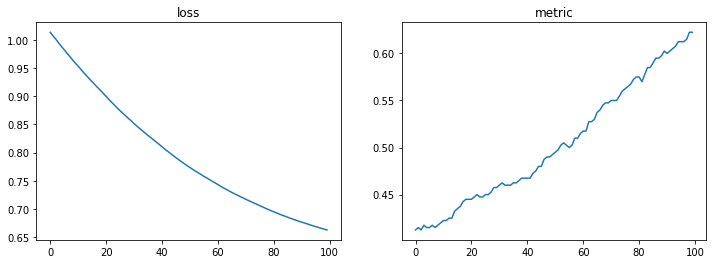

In [24]:
plt.figure(figsize=(12,4))
hist = history.history
plt.subplot(121)
plt.plot(hist['loss'])
plt.title('loss')
plt.subplot(122)
plt.plot(hist['acc'])
plt.title('metric')
pass

In [25]:
model.get_weights()

[array([[ 0.22816192],
        [-0.3955189 ],
        [ 0.13052003],
        [ 0.12258733],
        [-0.1864692 ]], dtype=float32), array([-0.49189493], dtype=float32)]

## Regularization and model evaluation

In [26]:
X.shape, y.shape

((400, 5), (400, 1))

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((300, 5), (100, 5), (300, 1), (100, 1))

### Add regularization to model

In [30]:
from keras.regularizers import l2

In [31]:
reg = l2()
model = Sequential()
model.add(
    layer=Dense(1, 
                input_dim=X.shape[1], 
                activation='sigmoid', 
                kernel_regularizer=reg))

In [32]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [33]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64, 
    epochs=300, 
    verbose=0,
    validation_data = (X_test, y_test))

In [34]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

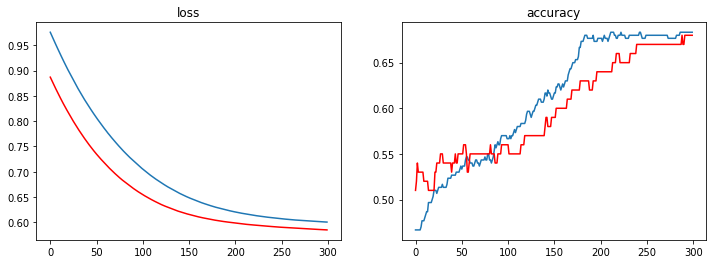

In [35]:
plt.figure(figsize=(12,4))
hist = history.history
plt.subplot(121)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'], c='red')
plt.title('loss')
plt.subplot(122)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'], c='red')
plt.title('accuracy')
pass

In [36]:
loss, acc = model.evaluate(X_test, y_test)

100/100 [==============================] - 0s 59us/step


In [37]:
loss, acc

(0.5850775122642518, 0.68)

## Saving and loading models

### Save model

In [38]:
s = model.to_json()
with open('logistic_model.json', 'w') as f:
    f.write(s) 

### Save weights

In [39]:
model.save_weights('logistic_wts.h5') 

### Load model and weights

In [40]:
from keras.models import model_from_json

In [41]:
with open('logistic_model.json') as f:
    s = f.read()
    model_1 = model_from_json(s)
model_1.load_weights('logistic_wts.h5')